### Lesson 2
#### Training a Neural Network 

This lesson aims to teach the basics of training a neural network. The function and physics are arbitrary; the goal is to touch the relevant parts of training. Still working with JAX, we now introduce the core transforms: **`jit`**, **`grad`**, **`vmap`**, and **`value_and_grad`**.

---

### `jit` — compile for speed
**What:** Compiles a pure function with XLA. First call traces/compiles (slow); subsequent calls with the **same shapes/dtypes and static args** are fast.  
**Call:** `fast_f = jax.jit(f, static_argnums=None, static_argnames=None)`  
**Static args:** `static_argnums` (ints/tuple of ints) or `static_argnames` (str/tuple of str) mark arguments as **compile-time constants** (not traced). Changing them triggers a recompile. Useful when an arg controls Python branching or shapes.

### `grad` — gradients of scalar outputs
**What:** Builds a function that returns ∂(scalar output)/∂(chosen args).  
**Call:** `df = jax.grad(f, argnums=0, has_aux=False)`

**Key params**
- `argnums`: int or tuple of ints selecting which argument(s) to differentiate.
- `has_aux=True`: if `f` returns `(value, aux)`, the transformed function returns `(grads, aux)`. The gradient is taken only of `value`.

**Notes**
- `f` must return a **scalar** (reduce with `.sum()` / `.mean()` if needed).
- For full Jacobians/Hessians: `jax.jacfwd`, `jax.jacrev`, `jax.hessian`.
### `vmap` — vectorize (auto-batch) a per-example function
**What:** Turns a function that acts on one example into one that acts on a **batch**—no Python loops.  
**Call:** `batched_f = jax.vmap(f, in_axes=0, out_axes=0)`  

**Key params**
- `in_axes`: for each argument, which axis to map (`0` = leading axis, `None` = broadcast the same value). Can be an int/None or a pytree mirroring the args.
- `out_axes`: where to place the mapped axis in the outputs (default `0`).
- `axis_name`: name the mapped axis to enable collectives inside `f` (e.g., `lax.pmean`).

**Notes**
- Compose with `jit` for speed: `jax.jit(jax.vmap(f))`.
- Combine with `grad` for per-example gradients.
### `value_and_grad` — value and gradient together
**What:** Computes `(value, grad)` in one pass (faster and numerically consistent).  
**Call:** `vg = jax.value_and_grad(f, argnums=0, has_aux=False)`  

**Key params**
- `argnums`: int or tuple of ints selecting which argument(s) to differentiate.
- `has_aux=True`: if `f` returns `(value, aux)`, then `vg(...)` returns `((value, aux), grads)`.

**Notes**
- Ideal for training steps where you need both loss and gradients.
- Return structure differs from `grad(..., has_aux=True)` (which returns `(grads, aux)`).


In [1]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import jax
import jax.random
import numpy as np

import optax

A neural network consists of two things, activation values $z_i$ and an activation function $f$. Assume that the activation values (i.e. inputs) into the particular layer *l* are called $x_l$. Then the vectors of activation values out of that layer $z_i$ can be given with a found given a certain vector of weights $w_i$ and biases $b_i$ in the following form:

\begin{equation}
z_i = \sum\limits_l w_{jl}x_l + b_j
\tag{1}
\end{equation}

then to get the actual output into the next layer, we also use an actication function $f(z_i)$. So:

\begin{equation}
x^{new}_i = f(z_i)
\tag{2}
\end{equation}

so if one wanted to make a really simple function of a neural network that took in as an input some $x$, along with a predescribed set of weights and biases $w$ and $b$, you could write :

In [2]:
def NN(x, params):
    """
    A simple neural network function
    x: input layer
    params: includes weights and biases
        w: weights
        b: biases
    The way to achieve multiple layers is to strucutre your weights and biases as a list of arrays. Each array in the list corresponds to the 
    weights and biases of a single layer in the neural network.
    
    """
    num_layers = len(params['weights'])
    for layer_idx, (w, b) in enumerate(zip(params['weights'], params['biases'])):
        x = jnp.matmul(w, x) + b
        if layer_idx < num_layers - 1:
            x = jnp.tanh(x)

    return x

The next step to actually performing this style of analysis will have to include initalizing a set of weights and baises that are to be optmized for. Of course you can decide any random set here but for the sake of convenience and to make the training slightly more robust, they are initiazlied randomly using jax. To do so we use the jax.random() function and then the jax.random.key(), .random.split(), and .random.normal() functions. 
- .key() takes an an integer and provides a "state" by which the randomness is deterministically achieved from
- .split() takes as an input a key and the number of deterministic splits to that key
- .normal() takes as an input a key and a shape indicator, then samples from a normal distribution an output that fits the shape indicator. 

So when we want to use jax but also randomly initiazle the weights and biases of our system, we have to get a bit creative:

In [3]:
def NN_init_params(key, num_neurons_layers):
    """
    Given a random jax key and a list of neurons in the layers of the network,
    return a dictionary of weights and biases

    """
    params = {}
    params['weights'] = []
    params['biases'] = []

    for lower_layer, higher_layer in zip( num_neurons_layers[:-1], num_neurons_layers[1:] ):
        key,subkey = jax.random.split( key )
        params['weights'].append( jax.random.normal( subkey,
                                        [higher_layer,lower_layer] ) /  
                                 jnp.sqrt( lower_layer ) )
        
    for num_neurons in num_neurons_layers[1:]:
        params['biases'].append( jnp.zeros( num_neurons) )
    
    return params

The logic here is as follows:
start with an empty parameter dictionary and empty lists for weights and baises. Afterwards pair up using the zip function the lower (input) layer size and higher (ouput) layer sizes. Make sure that the lower_layers apply for all layers upto the final and higher_layers apply to every layer expect for the first. Then split your key and create a list for the given layer that you're on of the size [higher_layer, lower_layer]. Divide by the square root of the lower layer for normalization purposes. In this case all the baises are set to 0. 

In [4]:
key = jax.random.key( 45 )

# number of neurons in each hidden layer:
num_hidden_1 = 30 
num_hidden_2 = 20

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [1, num_hidden_1, num_hidden_2, 1] )

In [5]:
NN( jnp.array([1.5]), params )

Array([-0.5805124], dtype=float32)

In machine learning, we often work in batches of data. For this purpose, the previously mentioned vmap function in handly to generalize any function (such as our neural network function) to take in instead of a single array of the size $[n_{input}]$ as seen above, a batch of size $[batchsize, n_{input}]$ instead. Here the in_axes is used to let the first input (i.e. the input array or data) to be mapped onto the first axis. The second input (i.e. the parameter list) doesn't need to be mapped to any axis. The out_axes makes it such that the first None input into the in_axes statement gets mapped out to the first (0th) output axes. NN_batch therefore is a new function, from NN, that takes in a batch of inputs instead of a single array. 

In [6]:
NN_batch = vmap( NN, in_axes = [0,None],
             out_axes = 0)

Now we're interested in seeing the effects that different inputs *x* have on the system. We sweep a variety of values of x to see the what the output of the function is going to be:

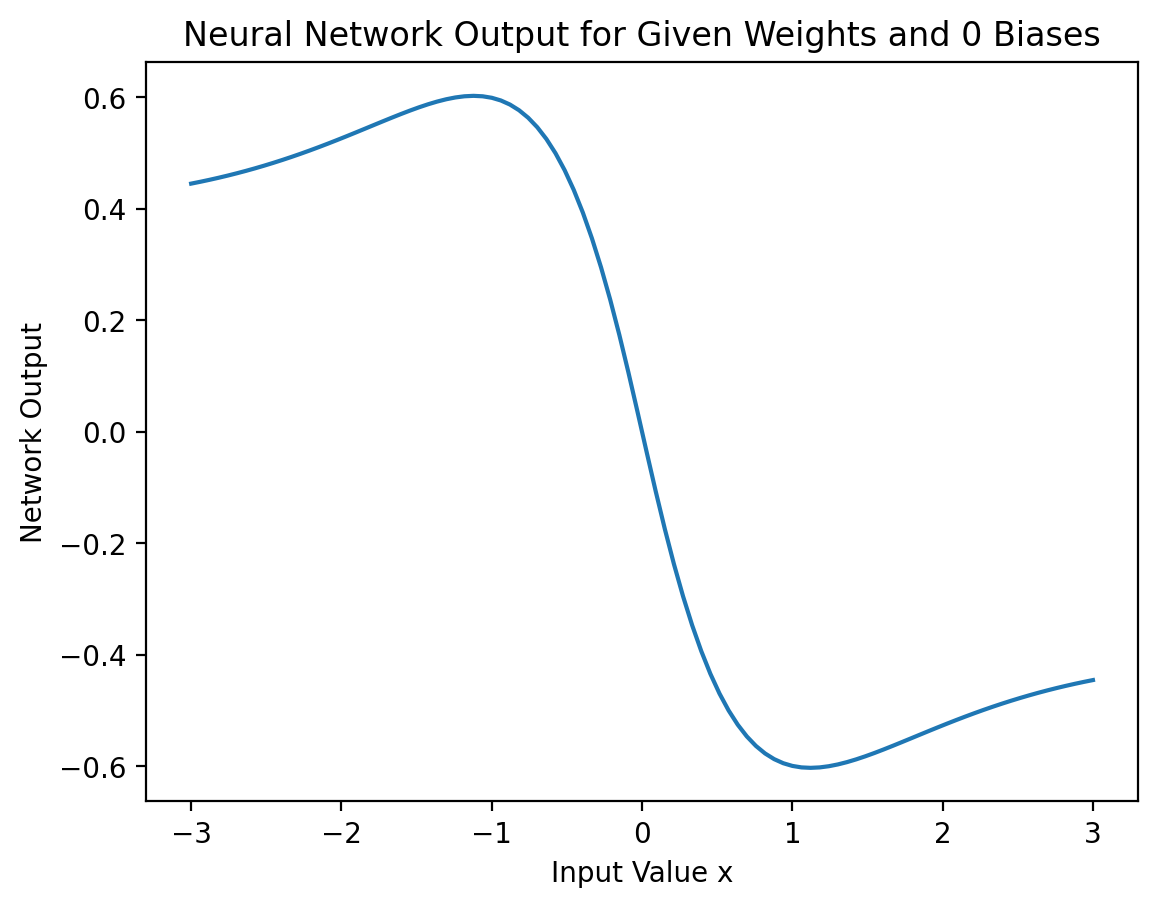

In [7]:
# create a sweep in x, but convert the shape to [100,1]
# where 100 is the batchsize and '1' is the original input dimension
# required for the network:
batchsize = 100
x = jnp.linspace( -3.0, +3.0, batchsize )[:,None]

plt.plot( x[:,0], NN_batch( x, params ) )
plt.title('Neural Network Output for Given Weights and 0 Biases')
plt.xlabel('Input Value x')
plt.ylabel('Network Output')
plt.show()

If you were to set the biases not to 0 but to some other value entirely (which during the training the neural network will) you get different plots:

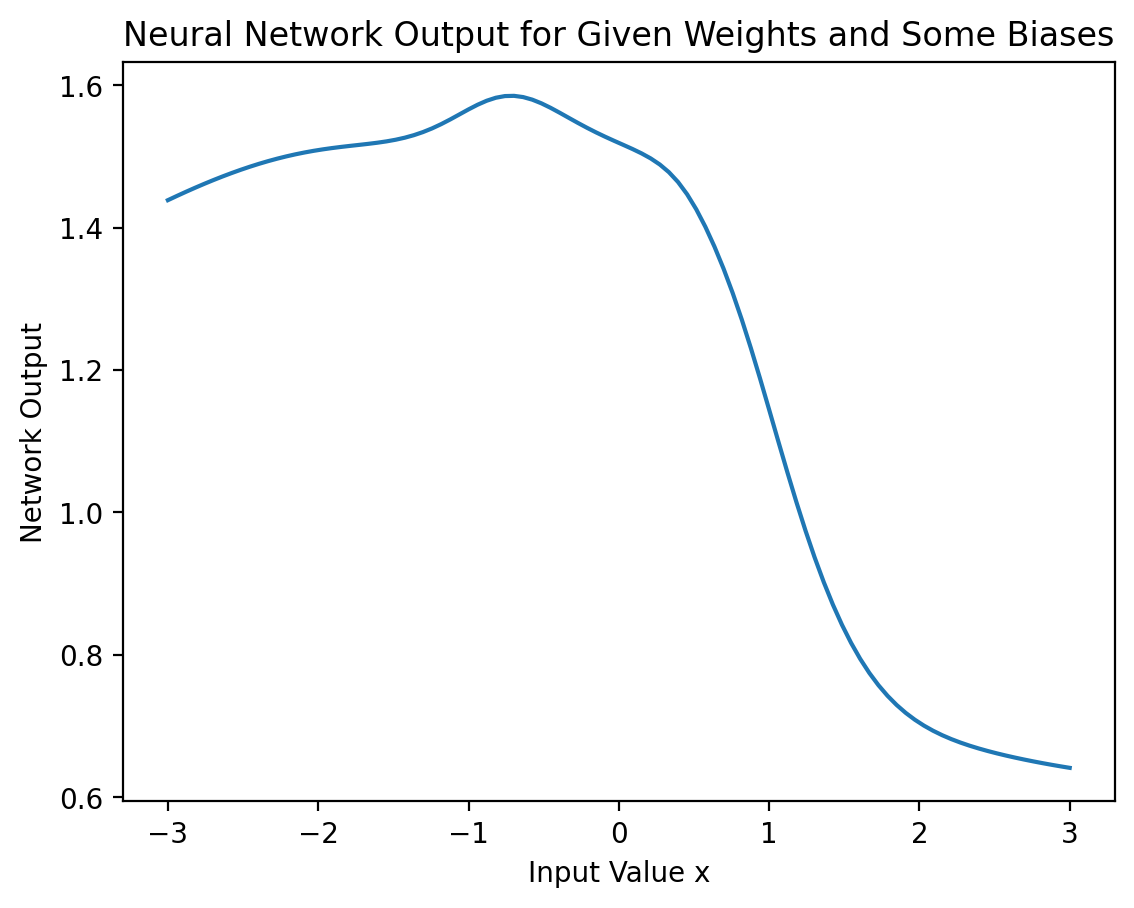

In [8]:
params['biases'] = [ jnp.full(num_hidden_1,-1.5), jnp.full(num_hidden_2, 1.3), jnp.full(1, 0.0) ]

plt.plot( x[:,0], NN_batch( x, params ) )
plt.title('Neural Network Output for Given Weights and Some Biases')
plt.xlabel('Input Value x')
plt.ylabel('Network Output')
plt.show()

To allow for the neural network to better achieve whatever purpose we desribe to it, it needs to train. For it to train, however, it needs to be able to understand what a desirable outcome even is. As such we define a (or a variety of) loss functions to guide it to some target output. These losses need to work on an average of the whole batch at one and usually have predefined/ predesribed shapes. Its also going to be important not only to track the loss of the state but the gradient of the loss as well. As such, we can use some of the previously mentioned jax functions. Here the gradient is taken with respect to the "params" argument (i.e. the weights and baises). Afterwards we can speed up the calculation process by using jit. 

In [9]:
# batch-averaged mean-square-error deviation between x and y_target:
def mse_loss_batch(x, y_target, params):
    return jnp.sum( ( NN_batch(x,params) - y_target )**2 ) / jnp.shape(x)[0]

# take gradient with respect to params (argument number '2' out of 0,1,2)
# also return value of loss:
mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=2)

mse_loss_batch_val_grad = jax.jit( mse_loss_batch_val_grad  )

Finally comes the actuall training process. We now have in our hands the following:
- A neural network function that takes in as an input a batch of data and a dictionary of baises and weights
- A initializer function that randomly initializes a dictionary of baises and weights
- A loss function that takes in as an input the state and target and calcualtes how far off we are from the desired target
- Two additions to the loss function that increase its complitation speed and calcualte its gradient

We now need only the following:
- A function to fit the data to
- An optimizer to do the fitting

The optimization process was covered in lesson 1 and the function (for our purposes today) is arbitrary. So:

In [10]:
# our "true" function that we want to fit using
# the neural network:
def F(q):
    return jnp.exp( - q**2 ) * jnp.sin( 5 * q )

def F1(q, A=10.0): #Rastrigin Function
    return A + (q**2 - A * jnp.cos(2 * jnp.pi * q))


def F2(q, a=20.0, b=0.2, c=2*jnp.pi): #Ackley Function
    # 1D Ackley: n=1 ⇒ sqrt(mean(x^2)) = |x|, mean(cos(cx)) = cos(c x)
    term1 = -a * jnp.exp(-b * jnp.abs(q))
    term2 = -jnp.exp(jnp.cos(c * q))
    return term1 + term2 + a + jnp.e


def F3(q, m=10): #Michalewicz Function
    return -jnp.sin(q) * (jnp.sin(q**2 / jnp.pi))**(2*m)

In [11]:
# again, initialize network randomly:

num_hidden_1 = 30 # number of neurons in hidden layer 1
num_hidden_2 = 20

subkey, key = jax.random.split(key)
params = NN_init_params( subkey, [1, num_hidden_1, num_hidden_2, 1] )

learning_rate = 1e-2

# get the optimizer:
optimizer = optax.adam( learning_rate )
# initialize the 'state' of the optimizer, by
# telling it about the initial values:
opt_state = optimizer.init( params )

In [12]:
# training parameters
num_training_batches = 1000
batchsize = 32
x_range = [-3.0, 3.0]
losses=[]

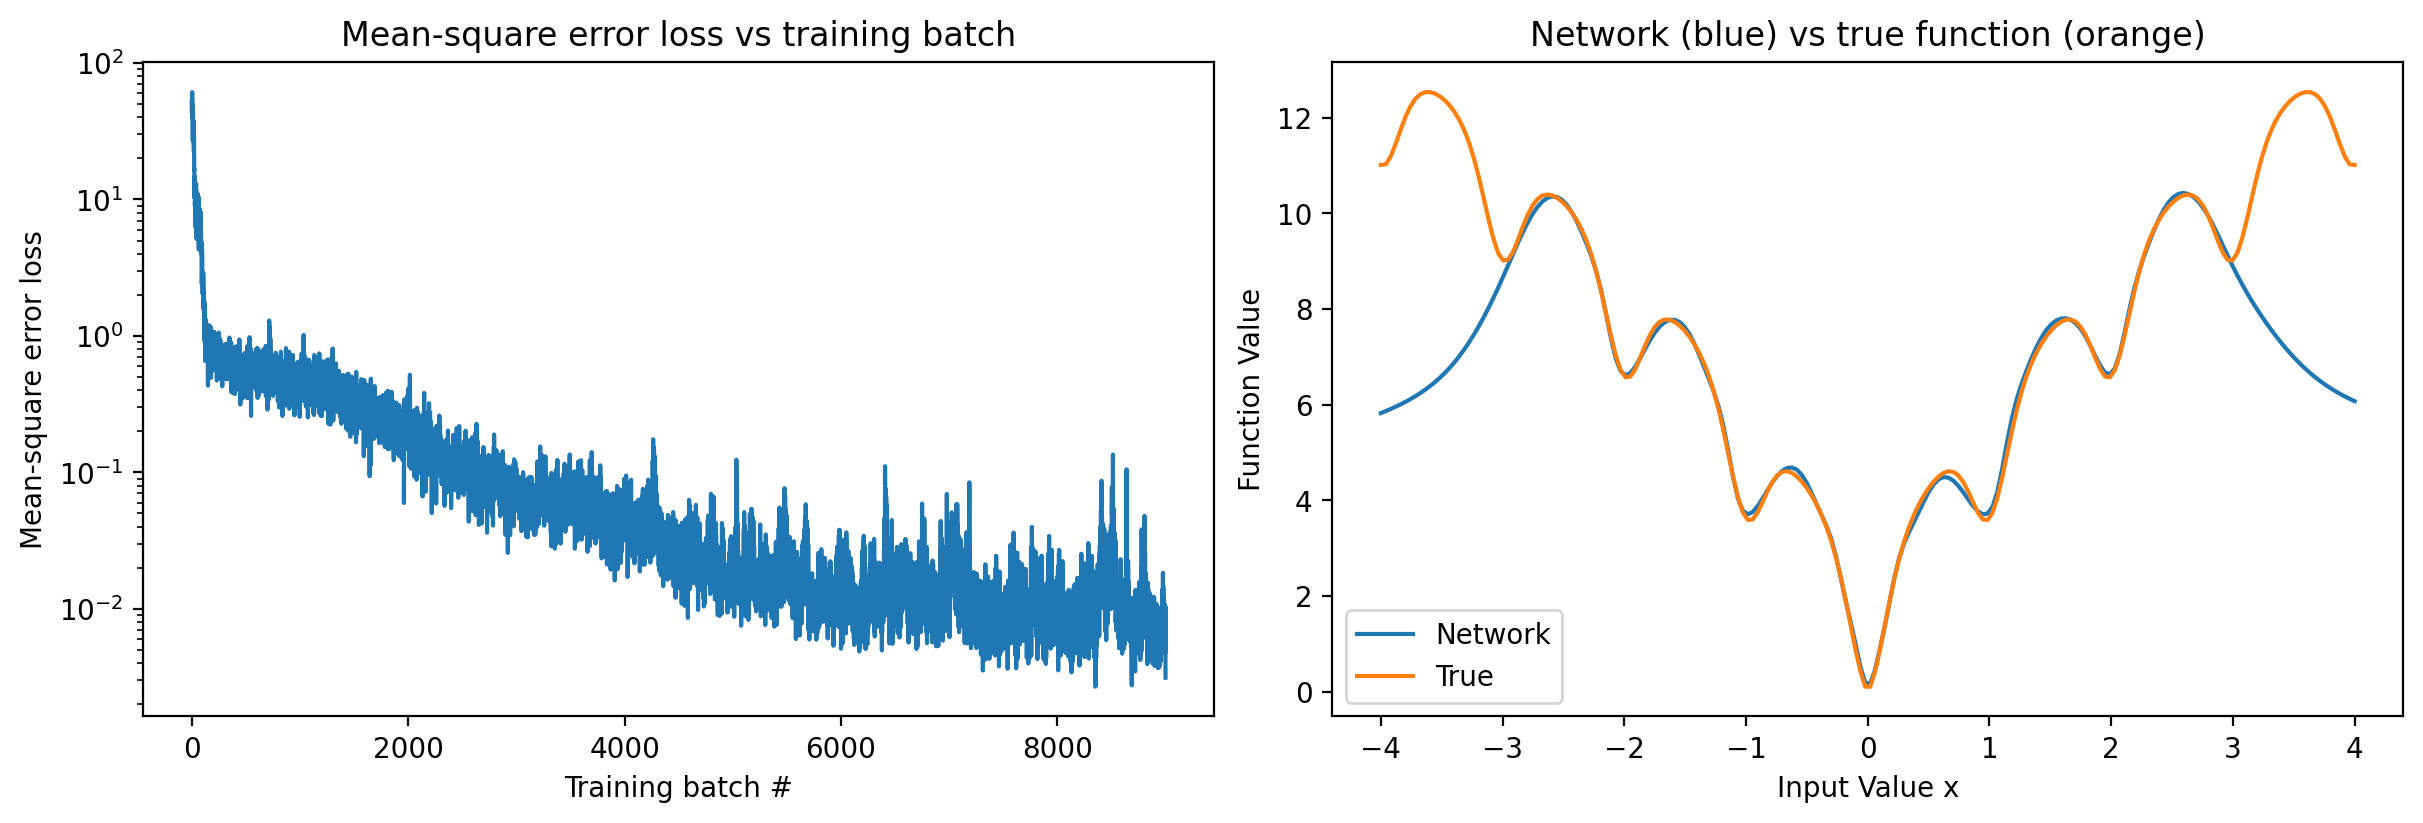

In [21]:
# run this cell multiple times to continue training!

for idx_batch in range(num_training_batches):
    # get training batch, by evaluating F at
    # random locations:
    subkey,key = jax.random.split( key )
    x = jax.random.uniform( subkey, [batchsize, 1], minval = x_range[0], maxval = x_range[1])
    F = F2
    y_target = F( x ) # Change the functional definition here to see how well the NN can fit different functions
    
    # get loss and its gradient with respect to network parameters:
    loss, grads = mse_loss_batch_val_grad( x, y_target, params )

    # update the network parameters:
    updates, opt_state = optimizer.update( grads, opt_state )
    params = optax.apply_updates( params, updates )

    # add the loss to the list:
    losses.append(loss)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')

# --- Left subplot: loss curve (log-scale) ---
ax1.plot(np.asarray(losses))
ax1.set_yscale("log")
ax1.set_title("Mean-square error loss vs training batch")
ax1.set_xlabel("Training batch #")
ax1.set_ylabel("Mean-square error loss")

# --- Right subplot: network vs. true function ---
x = jnp.linspace(-4.0, 4.0, 200)[:, None]
net_output = NN_batch(x, params)

ax2.plot(np.asarray(x).ravel(), np.asarray(net_output).ravel(), label="Network")
ax2.plot(np.asarray(x).ravel(), np.asarray(F(x)).ravel(), label="True")
ax2.set_title("Network (blue) vs true function (orange)")
ax2.set_xlabel("Input Value x")
ax2.set_ylabel("Function Value")
ax2.legend()

plt.show()

As you add more and more batches (so you run the above code block again and again), the blue curve converges onto the orange curve. You can also change the function to whatever you want to see how the fitting works for different functions